In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [2]:
#Education/Wage Data Set
train = pd.read_csv('Effect on Education')
train

,Wage,AFQT,Educ,Exper,Age,Meduc,Logwage
0,950,96,12,14,35,8,6.856462
1,797,90,16,11,33,14,6.680855
2,873,95,12,14,38,10,6.771935
3,1575,117,12,13,30,10,7.362010
4,654,121,17,12,34,11,6.483108
...,...,...,...,...,...,...,...
436,1313,107,12,11,28,12,7.180070
437,1105,119,16,9,30,11,7.007601
438,1386,109,16,10,34,4,7.234177
439,1063,90,12,14,32,8,6.968851


In [3]:
# split data into training and testing data
y = train.iloc[:, 0]
X = train.iloc[:, [1, 2, 3, 4, 5, 6]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

## EDA
Looking for significant variables

In [4]:
corr = train.corrwith(train.Wage).sort_values(ascending=False)
print(corr)

#Here we observe relatively low linear correlations with Wage- lets look at correlation with logWage

Wage       1.000000
Logwage    0.963846
AFQT       0.349504
Educ       0.339001
Meduc      0.209436
Age        0.197729
Exper      0.019706
dtype: float64


In [5]:
logcorr = train.corrwith(train.Logwage).sort_values(ascending=False)
print(logcorr)

#Comprable correlation results- (may suggest low levels of Heteroskedasticity in error terms)

Logwage    1.000000
Wage       0.963846
AFQT       0.370152
Educ       0.321197
Meduc      0.214142
Age        0.197037
Exper      0.052629
dtype: float64


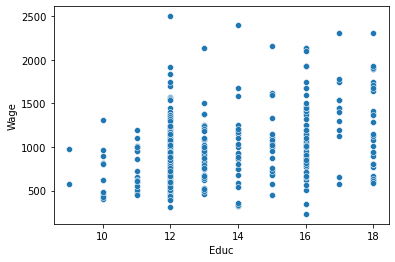

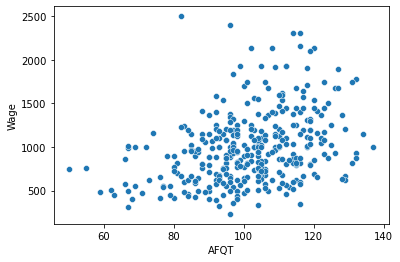

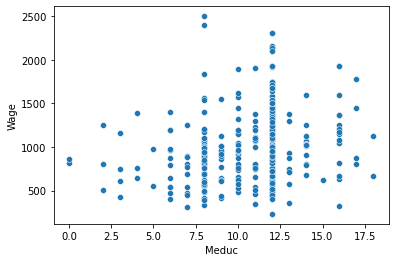

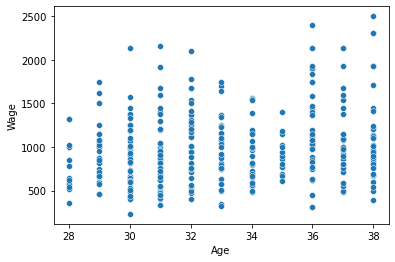

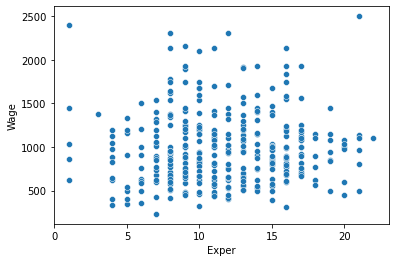

In [6]:
#Now, look for patterns in individual predictor scatterplots
sns.scatterplot(x=train.Educ, y=train.Wage)
plt.show()

sns.scatterplot(x=train.AFQT, y=train.Wage)
plt.show()

sns.scatterplot(x=train.Meduc, y=train.Wage)
plt.show()

sns.scatterplot(x=train.Age, y=train.Wage)
plt.show()

sns.scatterplot(x=train.Exper, y=train.Wage)
plt.show()

Observationally, we see a distinct non-linear relationship in the AFQT plot.

Less clearly, there appears to be some non-linearity in the Meduc  and Educ plots.

**Further EDA**

## Model
Naive model based on EDA results. Include visualizations

In [7]:
#Feel free to change this, wanted to get my EDA observations in a model
model = smf.ols(formula='Wage~I(AFQT**2)+Educ+Exper+Age+Meduc', data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Wage   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     16.88
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           6.24e-15
Time:                        21:46:31   Log-Likelihood:                -2578.8
No. Observations:                 352   AIC:                             5170.
Df Residuals:                     346   BIC:                             5193.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -690.3227    244.968     -2.818      0.005   -1172.137    -208.508
I(AFQT ** 2)     0.0290      0.008      3.587      0.000       0.013       0.045
Educ            46.2980     12.639      3.663      0.000      21.438      71.158
Exper           12.5470      6.355      1.974      0.049       0.048      25.046
Age             15.4948      7.907      1.960      0.051      -0.058      31.048
Meduc            8.1695      7.518      1.087      0.278      -6.618      22.957
==============================================================================
Omnibus:                       49.836   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.640
Skew:                           0.867   Prob(JB):                     8.39e-18
Kurtosis:                       4.535   Cond. No.                     1.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Very low $R^2$ value. Intercept term does not make sense in the context of our problem- as our predictors have little meaning as they approach zero. Let us force the regression through 0 by removing the intercept term.

In [8]:
model = smf.ols(formula='Wage~I(AFQT**2)+Educ+Exper+Age+Meduc-1', data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Wage   R-squared (uncentered):                   0.880
Model:                            OLS   Adj. R-squared (uncentered):              0.878
Method:                 Least Squares   F-statistic:                              509.2
Date:                Mon, 27 Feb 2023   Prob (F-statistic):                   2.28e-157
Time:                        21:46:40   Log-Likelihood:                         -2582.8
No. Observations:                 352   AIC:                                      5176.
Df Residuals:                     347   BIC:                                      5195.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
I(AFQT ** 2)     0.0292      0.008      3.570      0.000       0.013       0.045
Educ            36.1123     12.232      2.952      0.003      12.054      60.171
Exper           12.2555      6.417      1.910      0.057      -0.366      24.877
Age             -0.1809      5.676     -0.032      0.975     -11.345      10.983
Meduc            5.7265      7.543      0.759      0.448      -9.108      20.561
==============================================================================
Omnibus:                       59.144   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.247
Skew:                           0.983   Prob(JB):                     4.63e-22
Kurtosis:                       4.684   Cond. No.                     7.54e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Analysis
Check metrics/metrics for overfitting and assumption fulfillment

In [9]:
pred_wage = model.predict(train)
np.sqrt(((train.Wage - pred_wage)**2).mean())

371.8539158165525

In [10]:
pred_wage = model.predict(test)
np.sqrt(((test.Wage - pred_wage)**2).mean())

412.39708360766804

The RMSE values of the training data and the testing data are similar, indicating that there is no overfitting of the data. 

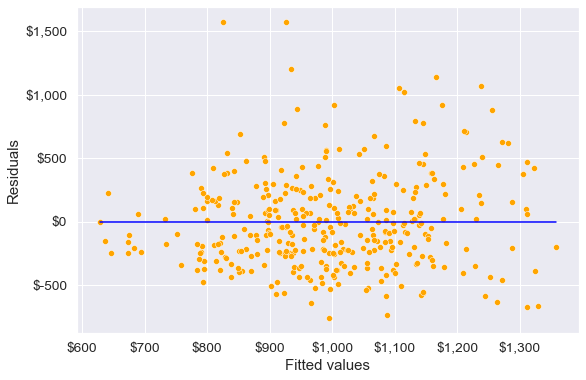

In [12]:
pred_wage = model.predict(train)

#Plotting residuals vs fitted values
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model.fittedvalues, y=model.resid,color = 'orange')
sns.lineplot(x = [pred_wage.min(),pred_wage.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.xaxis.set_major_formatter('${x:,.0f}')

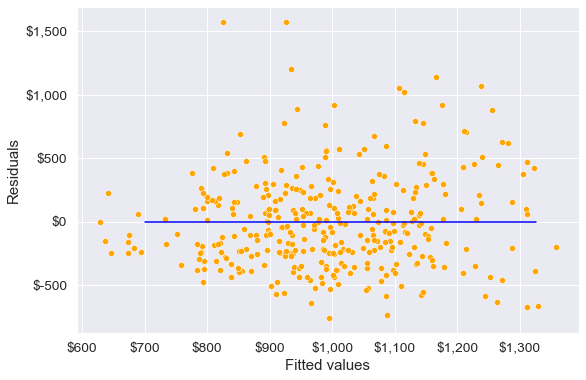

In [13]:
pred_wage = model.predict(test)

#Plotting residuals vs fitted values
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model.fittedvalues, y=model.resid,color = 'orange')
sns.lineplot(x = [pred_wage.min(),pred_wage.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.xaxis.set_major_formatter('${x:,.0f}')

The model seems to satisfy the non-linearity assumption, as we do not observe a strong pattern in the residuals around the line Residuals = 0. Residuals are distributed more or less in a similar manner on both sides of the blue line for all fitted values. We observe that the constant variance assumption is also satisfied. 

In [14]:
out = model.outlier_test()
np.sum((np.abs(out.student_resid)>3))

4

0

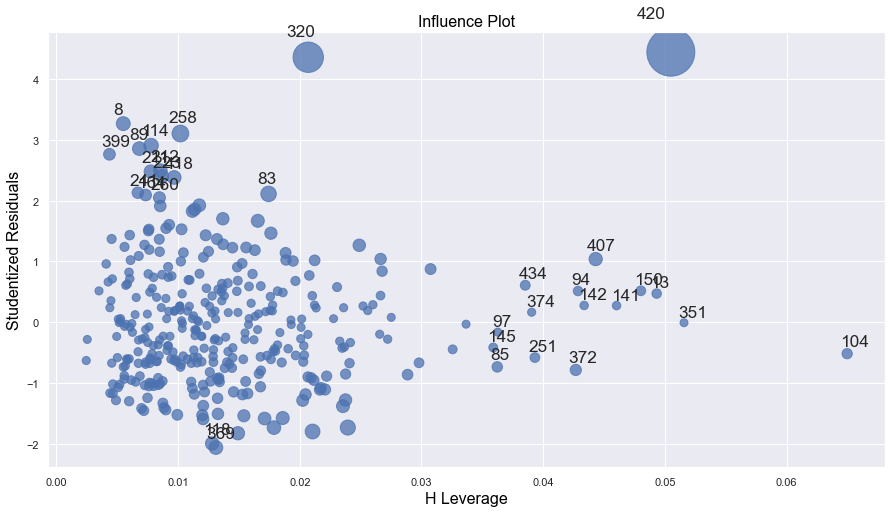

In [15]:
influence = model.get_influence()
leverage = influence.hat_matrix_diag

sns.set(rc={'figure.figsize':(15,8)})
sm.graphics.influence_plot(model);
out = model.outlier_test()
average_leverage = (model.df_model+1)/model.nobs
high_leverage_threshold = 4*average_leverage
np.sum(leverage>high_leverage_threshold)

In [16]:
train_filtered = train.drop(np.intersect1d(np.where(np.abs(out.student_resid)>3)[0],
                                           (np.where(leverage>high_leverage_threshold)[0])))
train.shape[0]-train_filtered.shape[0]

0

## Optimization 
Interaction terms, Transformations, Outliers, Colinearity, etc.

<AxesSubplot:>

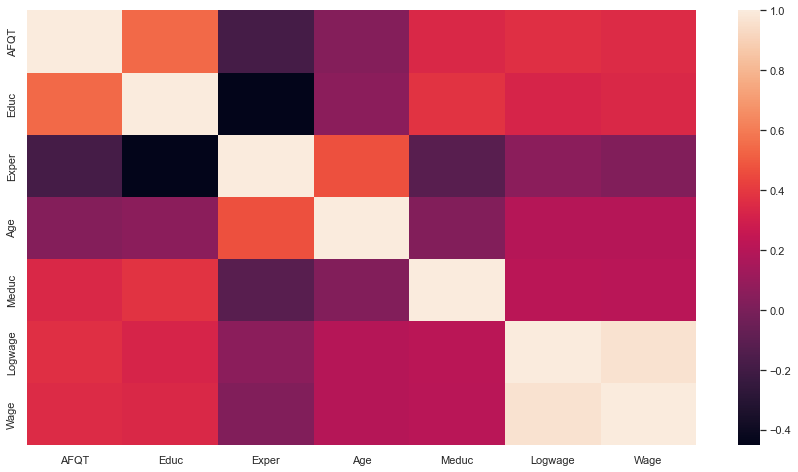

In [17]:
#Colinearity analysis
sns.heatmap(train.corr())

We see high correlations (>0.5) between: 
- Educ and AFQT
- Exper and Age

## Updated Model and Analysis
Report Metrics and assumption status of current model. Output results.

In [35]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Wage   R-squared (uncentered):                   0.880
Model:                            OLS   Adj. R-squared (uncentered):              0.878
Method:                 Least Squares   F-statistic:                              509.2
Date:                Mon, 27 Feb 2023   Prob (F-statistic):                   2.28e-157
Time:                        22:00:12   Log-Likelihood:                         -2582.8
No. Observations:                 352   AIC:                                      5176.
Df Residuals:                     347   BIC:                                      5195.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
I(AFQT ** 2)     0.0292      0.008      3.570      0.000       0.013       0.045
Educ            36.1123     12.232      2.952      0.003      12.054      60.171
Exper           12.2555      6.417      1.910      0.057      -0.366      24.877
Age             -0.1809      5.676     -0.032      0.975     -11.345      10.983
Meduc            5.7265      7.543      0.759      0.448      -9.108      20.561
==============================================================================
Omnibus:                       59.144   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.247
Skew:                           0.983   Prob(JB):                     4.63e-22
Kurtosis:                       4.684   Cond. No.                     7.54e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Model Assumptions:
Predictors and the response variable should be linear.


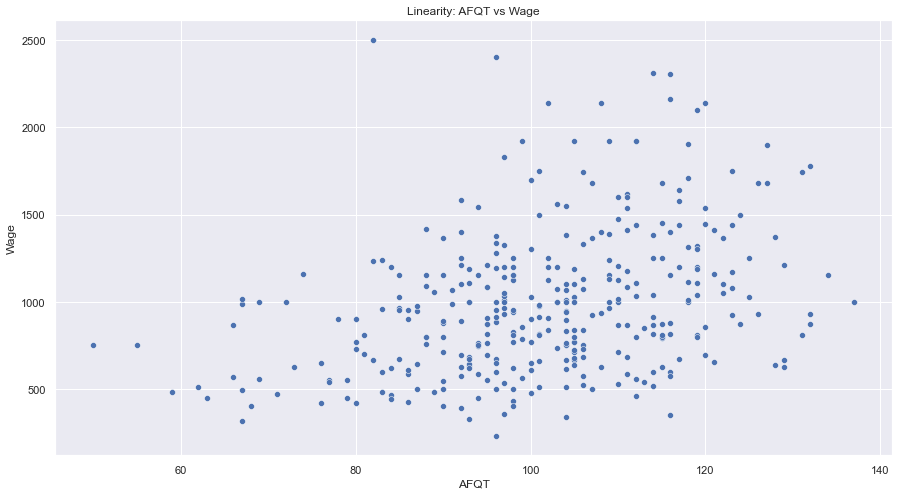

- Independence: The observations should be independent of each other.
The errors should be normally distributed.


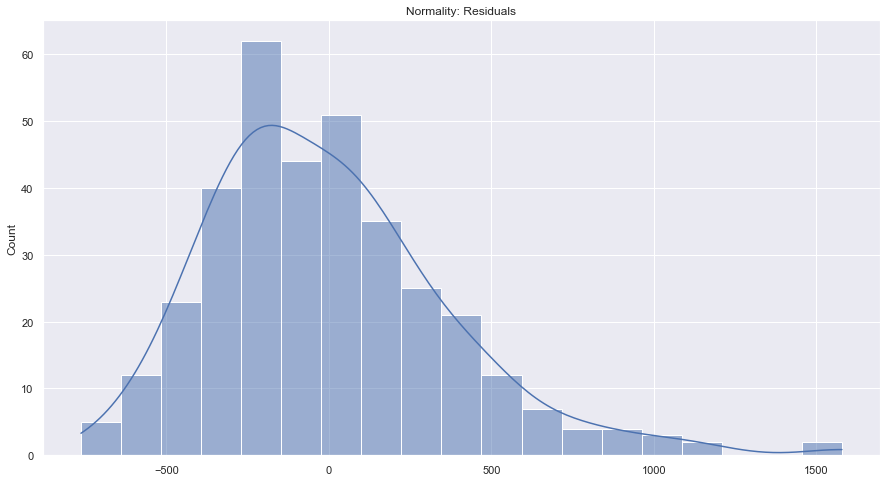

Homoscedasticity


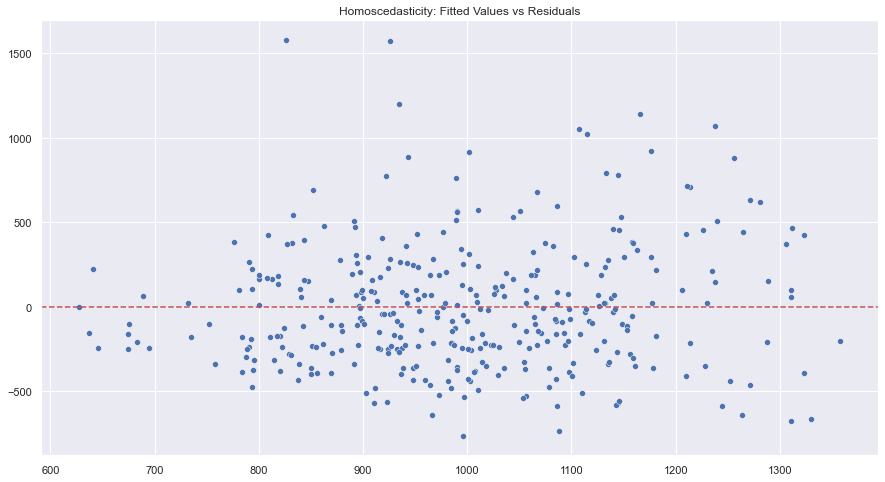

In [46]:
# Model assumptions
print("Model Assumptions:")
print("Predictors and the response variable should be linear.")
sns.scatterplot(data=train, x='AFQT', y='Wage')
plt.title("Linearity: AFQT vs Wage")
plt.show()

print("- Independence: The observations should be independent of each other.")
# No code needed - this is assumed to be true unless otherwise stated.

print("The errors should be normally distributed.")
sns.histplot(data=model.resid, kde=True)
plt.title("Normality: Residuals")
plt.show()

print("Homoscedasticity")
sns.scatterplot(data=train, x=model.predict(), y=model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Homoscedasticity: Fitted Values vs Residuals")
plt.show()


In [45]:
# Model performance
print("Model Performance:")
print("R-squared:", model.rsquared)
print("Adjusted R-squared:", model.rsquared_adj)
print("Root Mean Squared Error (RMSE):", np.sqrt(model.mse_resid))
print("Mean Absolute Error (MAE):", (np.abs(test.Wage - model.predict(test))).mean())

Model Performance:
R-squared: 0.8800586133049687
Adjusted R-squared: 0.8783303512488443
Root Mean Squared Error (RMSE): 374.52339671840065
Mean Absolute Error (MAE): 313.2175358089491
